XGBRegressor - Extreme Gradient Boosting

n_estimatiors - number of gradient boosted trees




In [ ]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import xgboost
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objs as go

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold

In [ ]:
data_path = "/content/drive/MyDrive/PK Data Science/master/codes/water_availability_prediction_in_Italy/data/"
river_arno_csv_name = "River_Arno.csv"
df = pd.read_csv(data_path+river_arno_csv_name)

In [ ]:
df.index = pd.to_datetime(df.Date)

In [ ]:
df_date_range = pd.date_range(start='1998-01-01', end='2020-12-06')
list_of_missing_dates = df_date_range.difference(df.index)
df_missing = pd.DataFrame(index=list_of_missing_dates, columns=df.columns)
df_with_missing = pd.concat([df, df_missing])

In [ ]:
def seasonal_mean(ts, n, lr=0.7):
    """
    Compute the mean of corresponding seasonal periods
    ts: 1D array-like of the time series
    n: Seasonal window length of the time series
    """
    out = np.copy(ts)
    for i, val in enumerate(ts):
        if np.isnan(val):
            ts_seas = ts[i-1::-n]  # previous seasons only
            if np.isnan(np.nanmean(ts_seas)):
                ts_seas = np.concatenate([ts[i-1::-n], ts[i::n]])  # previous and forward
            out[i] = np.nanmean(ts_seas) * lr
    return out

(1461, 2)
(1460, 2)
XGBoost - Root Mean Square Error (RMSE): 0.427
XGBoost - Mean Square Error (MSE): 0.182
XGBoost - Mean Absolute Error (MAE): 0.229
XGBoost - Mean: 1.308


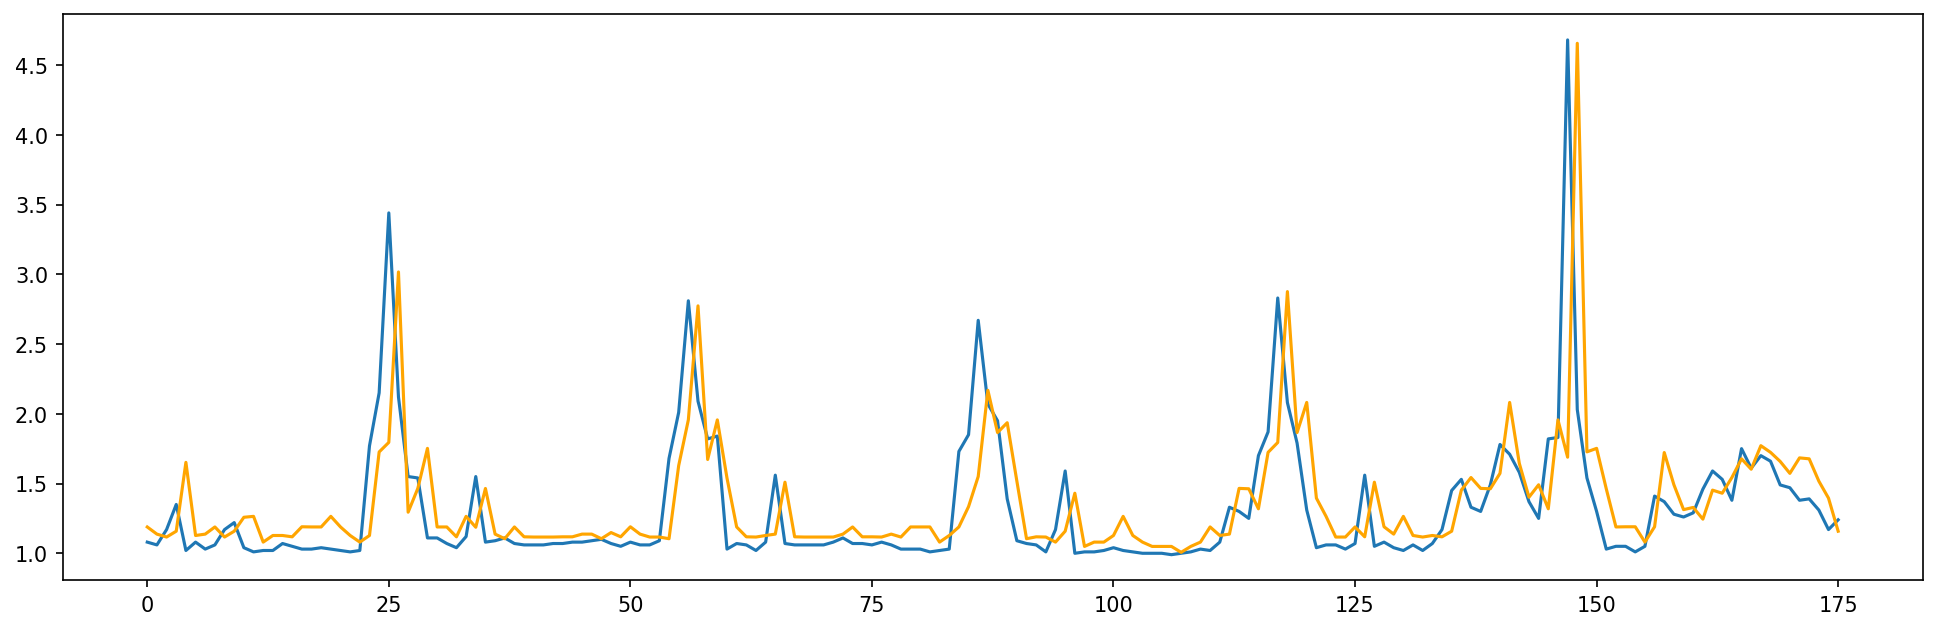

In [ ]:
df_hydrometry_with_missing = pd.DataFrame(df_with_missing['Hydrometry_Nave_di_Rosano'])
df_hydrometry_with_missing = df_hydrometry_with_missing.loc[df_hydrometry_with_missing.index.year.isin([2015,2016,2017,2018])]
df_hydrometry_with_missing.sort_index(inplace=True)
df_hydrometry_with_missing['seasonal_mean'] = seasonal_mean(df_hydrometry_with_missing['Hydrometry_Nave_di_Rosano'], n=12, lr=1.25)
df_hydrometry_with_missing = df_hydrometry_with_missing.drop(['Hydrometry_Nave_di_Rosano'], axis=1)


df_hydrometry_with_missing['target'] = df_hydrometry_with_missing.seasonal_mean.shift(-1)

print(df_hydrometry_with_missing.shape)

df_hydrometry_with_missing.dropna(inplace=True)

print(df_hydrometry_with_missing.shape)

# Extract features & labels
dates = df_hydrometry_with_missing.index
X = df_hydrometry_with_missing.iloc[:,0:1].values
y = df_hydrometry_with_missing.iloc[:, -1].values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.12, random_state = 0, shuffle=False)

reg = xgboost.XGBRegressor(objective='reg:squarederror', n_estimators=1000)

reg.fit(X_train, y_train)

predictions_xgb = reg.predict(X_test)

mse_xgb = mean_squared_error(y_test, predictions_xgb)
rmse_xgb = sqrt(mse_xgb)
mae_xgb = mean_absolute_error(y_test, predictions_xgb)

print("XGBoost - Root Mean Square Error (RMSE): %.3f" % rmse_xgb)
print("XGBoost - Mean Square Error (MSE): %.3f" % mse_xgb)
print("XGBoost - Mean Absolute Error (MAE): %.3f" % mae_xgb)
print("XGBoost - Mean: %.3f" % np.mean(y_test))

plt.figure(figsize=(16,5), dpi=150)
plt.plot(y_test)
plt.plot(predictions_xgb, color='orange')
plt.show()

XGBoost - Root Mean Square Error (RMSE): 0.441
XGBoost - Mean Square Error (MSE): 0.194
XGBoost - Mean Absolute Error (MAE): 0.234
XGBoost - Mean: 1.327


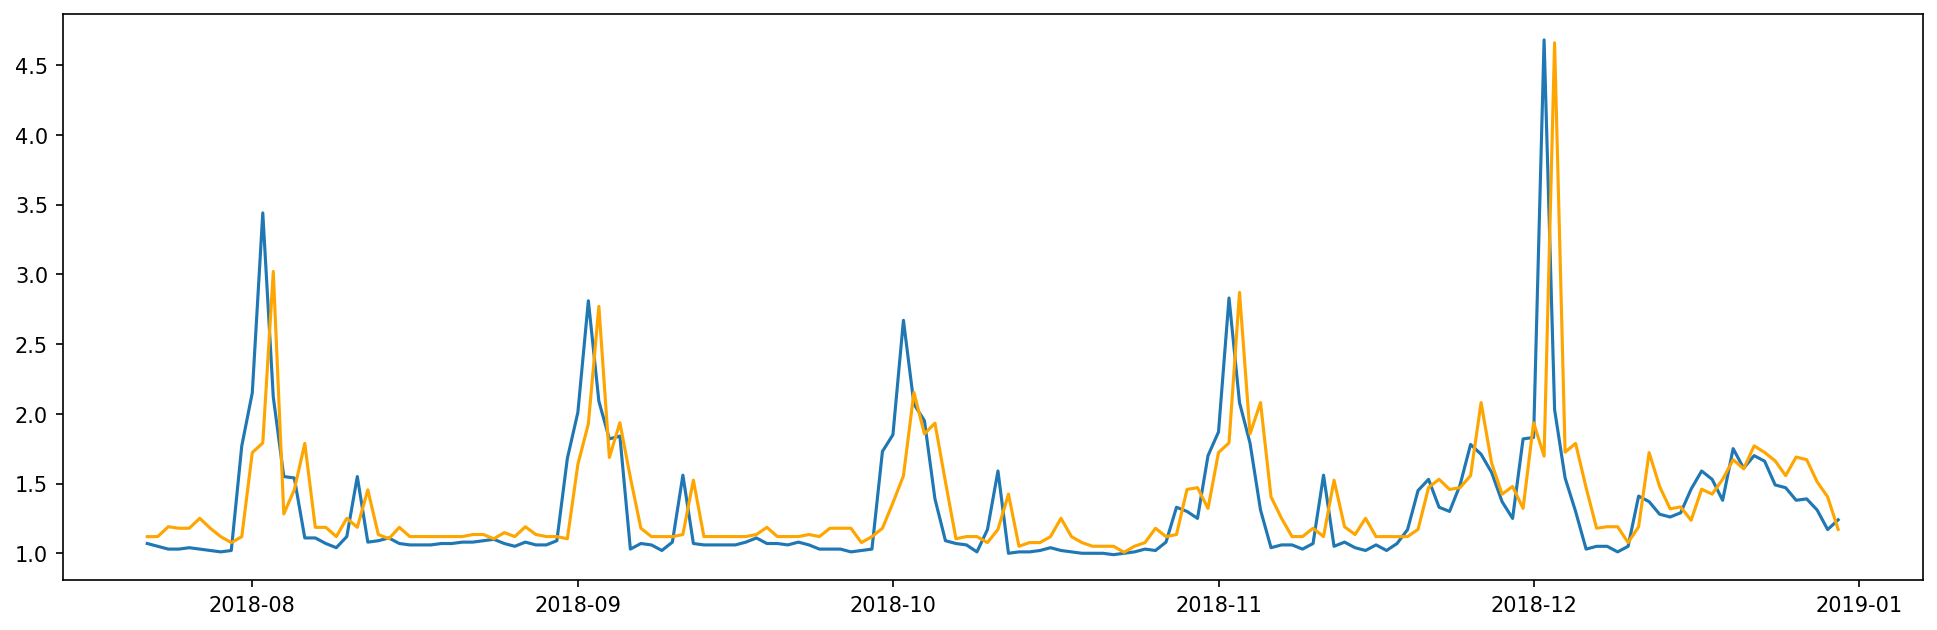

In [ ]:
tss = TimeSeriesSplit(n_splits = 8)

df_hydrometry_with_missing.sort_index(inplace=True)
df_hydrometry_with_missing
X = df_hydrometry_with_missing.drop(['target'], axis=1)
y = df_hydrometry_with_missing['target']

for train_index, test_index in tss.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]


reg = xgboost.XGBRegressor(objective='reg:squarederror', n_estimators=1000)

reg.fit(X_train, y_train)

predictions_xgb = reg.predict(X_test)
mse_xgb = mean_squared_error(y_test, predictions_xgb)
rmse_xgb = sqrt(mse_xgb)
mae_xgb = mean_absolute_error(y_test, predictions_xgb)

print("XGBoost - Root Mean Square Error (RMSE): %.3f" % rmse_xgb)
print("XGBoost - Mean Square Error (MSE): %.3f" % mse_xgb)
print("XGBoost - Mean Absolute Error (MAE): %.3f" % mae_xgb)
print("XGBoost - Mean: %.3f" % np.mean(y_test))

plt.figure(figsize=(16,5), dpi=150)
plt.plot(y_test.index, y_test.values)
plt.plot(y_test.index, predictions_xgb, color='orange')
plt.show()


In [ ]:
fig = px.line(x=y_test.index, y=y_test.values, markers=False)
fig.add_scatter(x=y_test.index, y=predictions_xgb, mode='lines')
fig.update_traces(connectgaps=False)
fig.update_layout(hovermode="x unified")
fig.update_xaxes(showspikes=True)
fig.update_yaxes(showspikes=True)
fig.show()

Metryka RMSE dla modelu wynosła 0.441. Wynik został oceniony na dość dobry, dzięki czemu można było wniosokować o dobrze wyuczonym modelu. Analiza wykresu wartości rzeczywistych oraz przewidywanych przyniosła podejrzenia o poprawności i przydatności modelu. Przesunięcie wartości przewidzianych o jeden dzień w przód zostało zinterpretowane jako niepoprawne działanie modelu. 






https://stackoverflow.com/questions/52252442/how-to-handle-shift-in-forecasted-value

Zastosowanie normalizacji dla cechy Hydrometry_Nave_di_Rosano

                   0
2015-01-01  0.160489
2015-01-02  1.757120
2015-01-03  0.302412
2015-01-04  0.586258
2015-01-05  0.142749
...              ...
2018-07-17 -0.478163
2018-07-18 -0.389461
2018-07-19 -0.708787
2018-07-20 -0.762008
2018-07-21 -0.744268

[1298 rows x 1 columns]
XGBoost - Root Mean Square Error (RMSE): 0.441
XGBoost - Mean Square Error (MSE): 0.194
XGBoost - Mean Absolute Error (MAE): 0.234
XGBoost - Mean: 1.327


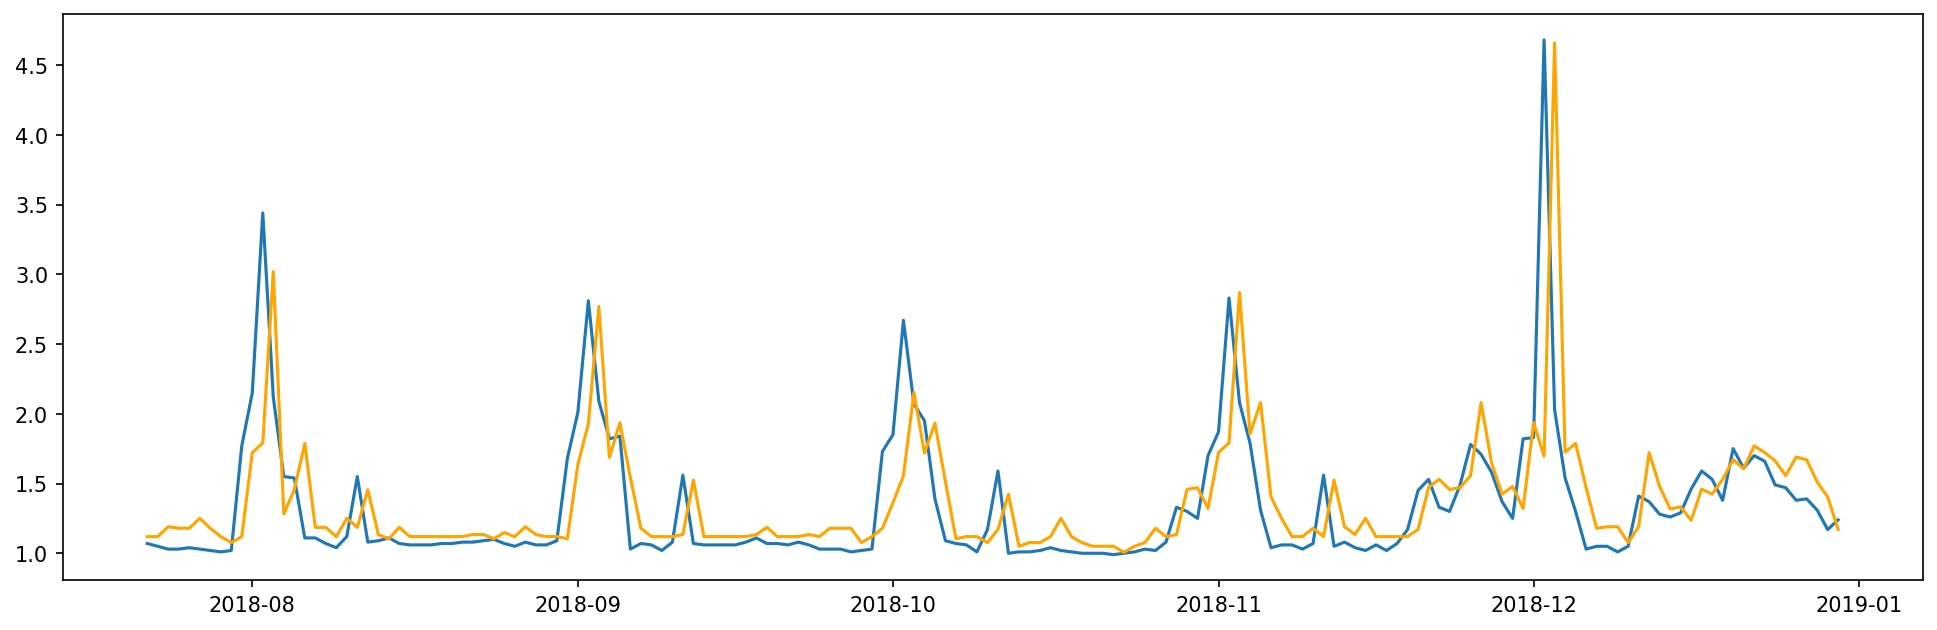

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, index=X.index)

for train_index, test_index in tss.split(X_scaled):
    X_scaled_train, X_scaled_test = X_scaled.iloc[train_index, :], X_scaled.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

print(X_scaled_train)
reg = xgboost.XGBRegressor(objective='reg:squarederror', n_estimators=1000)

reg.fit(X_scaled_train, y_train)

predictions_xgb_sc = reg.predict(X_scaled_test)
mse_xgb = mean_squared_error(y_test, predictions_xgb)
rmse_xgb = sqrt(mse_xgb)
mae_xgb = mean_absolute_error(y_test, predictions_xgb)

print("XGBoost - Root Mean Square Error (RMSE): %.3f" % rmse_xgb)
print("XGBoost - Mean Square Error (MSE): %.3f" % mse_xgb)
print("XGBoost - Mean Absolute Error (MAE): %.3f" % mae_xgb)
print("XGBoost - Mean: %.3f" % np.mean(y_test))

plt.figure(figsize=(16,5), dpi=150)
plt.plot(y_test.index, y_test.values)
plt.plot(y_test.index, predictions_xgb_sc, color='orange')
plt.show()